# Part 3 Challenge

Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences

In [1]:
#import necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### 3.1 Examination, cleaning, and evaluation of the data

In [2]:
# read in and examine logins file
driverDF = pd.read_json('ultimate_data_challenge.json')
driverDF.head(10)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,iPhone,0.0,True,100.0,10.56,5.0
6,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,Android,0.0,False,100.0,3.95,4.0
7,Winterfell,2,2014-01-28,5.0,1.00,2014-01-29,iPhone,0.0,False,100.0,2.04,5.0
8,Winterfell,2,2014-01-21,4.5,1.00,2014-02-01,Android,0.0,False,100.0,4.36,5.0
9,Winterfell,1,2014-01-03,NaN,1.00,2014-01-05,Android,0.0,False,0.0,2.37,5.0


In [3]:
#Check for missing values
driverDF.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [4]:
#Replace the numeric missing values with their mean
driverDF['avg_rating_of_driver'] = driverDF['avg_rating_of_driver'].fillna(driverDF['avg_rating_of_driver'].mean())
driverDF['avg_rating_by_driver'] = driverDF['avg_rating_by_driver'].fillna(driverDF['avg_rating_by_driver'].mean())

# Replace missing values with 'unknown'
driverDF['phone'] = driverDF.fillna('unknown')

In [5]:
driverDF.dtypes #(find the types)

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [6]:
# My time data is not in datetime format so I will convert the important time stamps
driverDF['signup_date'] = pd.to_datetime(driverDF['signup_date'])
driverDF['last_trip_date'] = pd.to_datetime(driverDF['last_trip_date'])

#check that they're all correct
driverDF.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

In [7]:
# Find out if they have been active in the last 30 days.
from datetime import datetime, timedelta

# Find when the data was last pulled and subtract 30 days from that number
pullDate = driverDF['last_trip_date'].max()
cutOff = pullDate - timedelta(days=30)

print('The assumed pull date is', pullDate)
print('30 days prior to our pull date is', cutOff)

The assumed pull date is 2014-07-01 00:00:00
30 days prior to our pull date is 2014-06-01 00:00:00


In [8]:
# Now with a boolean as an integer we will find if they were active 30 days prior to June 1

driverDF['active'] =  0
driverDF['active'] = (driverDF['last_trip_date'] > cutOff).astype('int')

In [9]:
#Find the number of active users

#Initalize data frame
activeUsers = pd.DataFrame()
inactiveUsers = pd.DataFrame()

#Create frames for different user groups
activeUsers = driverDF[driverDF['active'] == 1]
inactiveUsers = driverDF[driverDF['active'] == 0]

activeUsers.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,King's Landing,15.4,True,46.2,3.67,5.0,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,King's Landing,20.0,True,80.0,2.36,4.9,1
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,Winterfell,0.0,True,100.0,10.56,5.0,1
13,King's Landing,0,2014-01-29,4.0,1.38,2014-06-08,King's Landing,50.0,False,50.0,3.04,5.0,1
16,King's Landing,1,2014-01-11,5.0,1.00,2014-06-28,King's Landing,0.0,True,50.0,10.86,3.0,1


In [10]:
print('The number of active users is', len(activeUsers))
print('The number of inactive users is', len(inactiveUsers))
print('The decimal percentage of active users is', len(activeUsers)/len(driverDF))

The number of active users is 18310
The number of inactive users is 31690
The decimal percentage of active users is 0.3662


#### Percentage of active users
It appears about 37% of our users that joined in January are still active users (by our 30 day defintion) as of July 1.

#### Visualization of the data

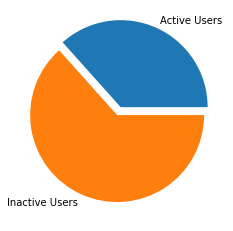

In [11]:
#Find percentage of active and inactive users
x = len(activeUsers)/len(driverDF)
y = len(inactiveUsers)/len(driverDF)
mylabels = ["Active Users", "Inactive Users"]

#plot them in pie chart
plt.pie([x,y], labels = mylabels, explode = [0.1, 0])
plt.show()

In [12]:
#Now lets find the percentage of active users who are Ultimate Black users

activeBlack = len(activeUsers[activeUsers['ultimate_black_user']==1])/len(activeUsers)
inactiveBlack = len(inactiveUsers[inactiveUsers['ultimate_black_user']==1])/len(inactiveUsers)
inactiveNotBlack = len(inactiveUsers[inactiveUsers['ultimate_black_user']==0])/len(inactiveUsers)

In [13]:
print('Out of all active users', "{:.0%}".format(activeBlack), 'are Ultimate Black members.')
print('Out of all inactive users', "{:.0%}".format(inactiveBlack), 'are Ultimate Black members.')
print('Out of all inactive users', "{:.0%}".format(inactiveNotBlack), 'are not Ultimate Black members.')
print('Out of all the users in this data frame', "{:.0%}".format(len(driverDF[driverDF['ultimate_black_user']==1])/len(driverDF)), 'are Ultimate Black members.')

Out of all active users 51% are Ultimate Black members.
Out of all inactive users 30% are Ultimate Black members.
Out of all inactive users 70% are not Ultimate Black members.
Out of all the users in this data frame 38% are Ultimate Black members.


Based on these percentages we can make the assumption that if you're an Ultimate Black member you're more likely to be an active user of our product. A takeaway can be for us can be to increase membership.

In [14]:
#indexes for various points of interest
ultimateIndex = (driverDF[driverDF['ultimate_black_user']==1]).index
activeIndex = (driverDF[driverDF['active']==1]).index
inactiveIndex = (driverDF[driverDF['active']==0]).index

### 3.1 Predictive modeling

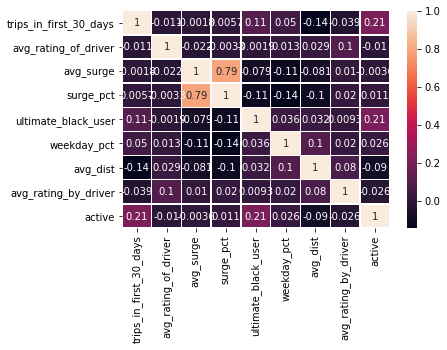

In [15]:
#Examine for correlations
sns.heatmap(driverDF.corr(), linewidths=.5, annot=True);

In [16]:
#removing confunding factors from our data
modelData = driverDF
modelData.drop(['signup_date','avg_surge', 'phone', 'surge_pct', 'last_trip_date'], inplace=True, axis=1)

#adjust the ultimate black user boolean to an integer
modelData['ultimate_black_user'] = modelData['ultimate_black_user'].astype('int')

#adjust the city to an integer
cityDict = {'Winterfell': 0, 'Astapor': 1, "King's Landing": 2}
modelData['city'] = modelData['city'].replace(cityDict)

modelData.head()

,city,trips_in_first_30_days,avg_rating_of_driver,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,2,4,4.7,1,46.2,3.67,5.0,1
1,1,0,5.0,0,50.0,8.26,5.0,0
2,1,3,4.3,0,100.0,0.77,5.0,0
3,2,9,4.6,1,80.0,2.36,4.9,1
4,0,14,4.4,0,82.4,3.13,4.9,0


array([[<AxesSubplot:title={'center':'city'}>,
        <AxesSubplot:title={'center':'trips_in_first_30_days'}>,
        <AxesSubplot:title={'center':'avg_rating_of_driver'}>],
       [<AxesSubplot:title={'center':'ultimate_black_user'}>,
        <AxesSubplot:title={'center':'weekday_pct'}>,
        <AxesSubplot:title={'center':'avg_dist'}>],
       [<AxesSubplot:title={'center':'avg_rating_by_driver'}>,
        <AxesSubplot:title={'center':'active'}>, <AxesSubplot:>]],
      dtype=object)

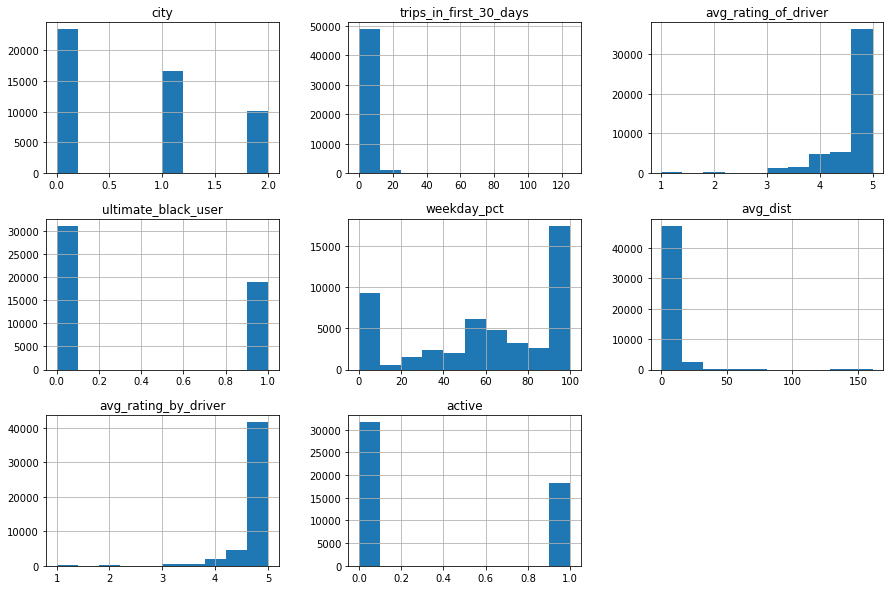

In [17]:
modelData.hist(figsize = (15,10))

None of the above histograms appear to be normally distributed.

#### Our first attempt model will be Random Forest



# NOTE TO SELF FIND FEATURE IMPORTANCE AFTER YOU FIND THE BEST MODEL

In [24]:
from sklearn.model_selection import train_test_split

#Define the features and predictor
X = modelData.drop('active', inplace = False, axis = 1)
y = modelData['active']

#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)